<a href="https://colab.research.google.com/github/rrezendes/marketing_campaign/blob/master/rrezende_iFood_rfm_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFood RFM Analysis





# 1.Imports, connections and transformation

In [0]:
#@title Libraries importing
#@libraries
#importing libraries
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pydrive to google drive connection
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#@title Authentication
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#@title Reading the file
#google drive file link (ml_project1_data.csv)
link = 'https://drive.google.com/open?id=1EcraG_N9CYY-YPnf9AHCyag9GtKMl9oF' # The shareable link

#takes the file ID
fluff, id = link.split('=')

#download and csv read
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ifood_file_test.csv')  
csv_base = pd.read_csv('ifood_file_test.csv')

In [0]:
#@title New Dataframe
df = csv_base


In [0]:
#@title Transformation

df['Frequency'] = df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumWebPurchases']
df['Revenue'] = df['MntFishProducts'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']

# 2. Analysis

## 2.1. Recency

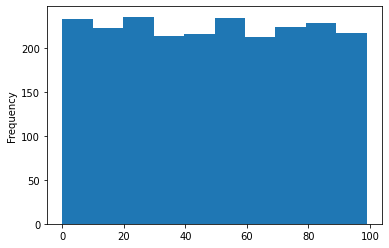

In [0]:
#@title Histogram
df['Recency'].plot.hist()

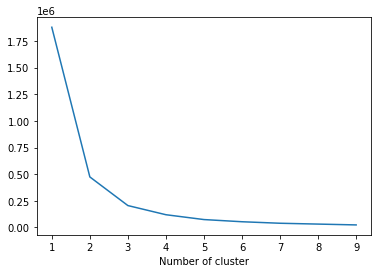

In [0]:
#@title Number of clusters

#Calculate how many clusters we need to K-means algorithm applying Elbow Method

from sklearn.cluster import KMeans

sse={}
tx_recency = df[['Recency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [0]:
#@title Clustering
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Recency']])
df['RecencyCluster'] = kmeans.predict(df[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df = order_cluster('RecencyCluster', 'Recency',df,False)

df.groupby('RecencyCluster').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,597.0,85.879397,7.690676,73.0,79.0,86.0,93.0,99.0
1,598.0,59.167224,7.637218,47.0,53.0,59.0,65.0,72.0
2,547.0,33.513711,7.197711,22.0,27.0,33.0,40.0,46.0
3,498.0,10.082329,6.431128,0.0,4.0,10.0,16.0,21.0


## 2.2. Frequency

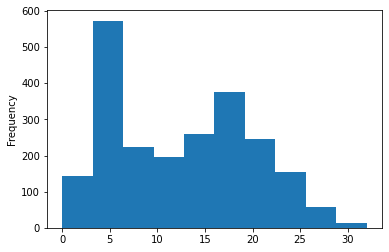

In [0]:
#@title Histogram
df['Frequency'].plot.hist()

In [0]:
#@title Clustering
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Frequency']])
df['FrequencyCluster'] = kmeans.predict(df[['Frequency']])

#order the frequency cluster
df = order_cluster('FrequencyCluster', 'Frequency',df,True)

#see details of each cluster
df.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,894.0,5.091723,1.545314,0.0,4.00,5.0,6.0,8.0
1,499.0,12.414830,1.923815,9.0,11.00,13.0,14.0,15.0
2,547.0,18.416819,1.703780,16.0,17.00,18.0,20.0,21.0
3,300.0,24.206667,2.136783,22.0,22.75,24.0,25.0,32.0


## 2.3. Revenue

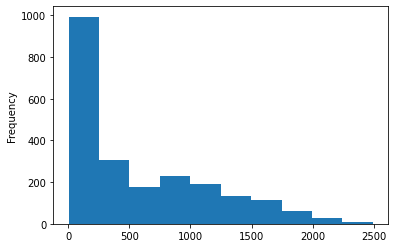

In [0]:
#@title Histogram
df['Revenue'].plot.hist()

In [0]:
#@title Clustering
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['Revenue']])
df['RevenueCluster'] = kmeans.predict(df[['Revenue']])


#order the cluster numbers
df = order_cluster('RevenueCluster', 'Revenue',df,True)

#show details of the dataframe
df.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1109.0,92.082056,84.990069,4.0,33.00,54.0,123.00,322.0
1,428.0,553.834112,147.622558,335.0,406.50,542.0,699.25,810.0
2,447.0,1075.436242,162.620855,818.0,931.00,1054.0,1211.50,1391.0
3,256.0,1712.886719,229.976041,1400.0,1534.75,1669.0,1879.25,2491.0


## 2.4. Overallscore

In [0]:
#@title Overallscore
df['OverallScore'] = df['RecencyCluster'] + df['FrequencyCluster'] + df['RevenueCluster']
df.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Recency,Frequency,Revenue
OverallScore,,,
0,85.690083,5.181818,55.826446
1,64.402778,6.236111,95.197917
2,44.133333,6.993651,130.476190
3,36.133159,9.584856,269.514360
4,52.452675,15.341564,720.502058
5,51.671642,18.141791,972.470149
6,42.606557,20.409836,1158.774590
7,27.582192,21.000000,1326.958904
8,18.505263,22.357895,1413.221053


In [0]:
#@title Segment
df['Segment'] = 'Low-Value'
df.loc[df['OverallScore']>2,'Segment'] = 'Mid-Value' 
df.loc[df['OverallScore']>5,'Segment'] = 'High-Value' 

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Frequency,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,22,1529,1,3,3,7,High-Value
1,6260,1955,Master,Together,82384.0,0,0,2012-11-19,55,984,51,432,180,120,190,1,3,10,13,1,0,0,1,0,0,0,3,11,1,26,1767,1,3,3,7,High-Value
2,8717,1975,PhD,Married,80427.0,0,1,2012-09-12,56,1149,71,449,69,71,26,1,11,8,8,5,0,0,0,0,0,0,3,11,0,27,1809,1,3,3,7,High-Value
3,2437,1989,Graduation,Married,NaN,0,0,2013-06-03,69,861,138,461,60,30,61,1,6,5,12,3,0,1,0,1,0,0,3,11,0,23,1550,1,3,3,7,High-Value
4,3428,1991,PhD,Together,68682.0,0,0,2013-10-06,56,919,0,505,99,30,45,1,4,9,10,2,0,0,0,0,0,0,3,11,0,23,1553,1,3,3,7,High-Value


## 2.5. RFM Distribution


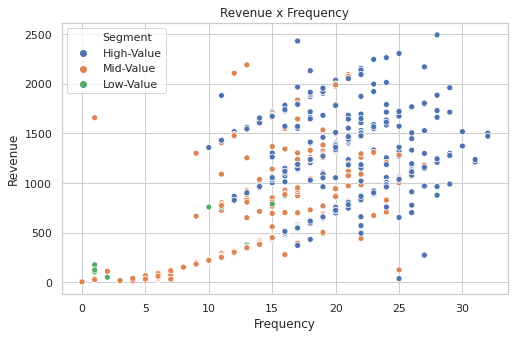

In [0]:
#@title Revenue x Frequency
sns.set_style("whitegrid")
ax = sns.scatterplot(x=df['Frequency'], y=df['Revenue'], hue=df['Segment'], data=df)
plt.title("Revenue x Frequency");
sns.set(rc={'figure.figsize':(8,5)})


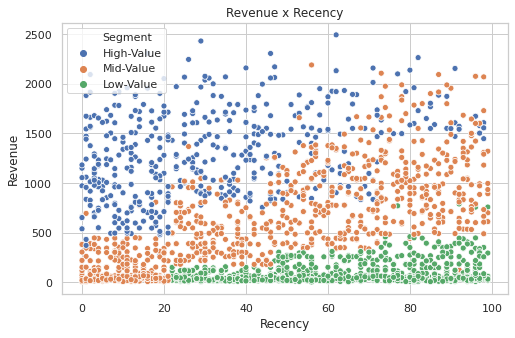

In [0]:
#@title Revenue x Recency
sns.set_style("whitegrid")
ax = sns.scatterplot(x=df['Recency'], y=df['Revenue'], hue=df['Segment'], data=df)
sns.set(rc={'figure.figsize':(8,5)})
plt.title("Revenue x Recency");


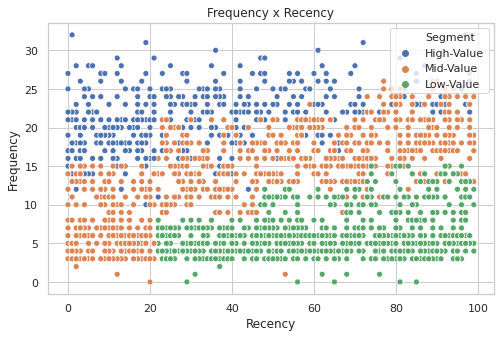

In [0]:
#@title Frequency x Recency
sns.set_style("whitegrid")
ax = sns.scatterplot(x=df['Recency'], y=df['Frequency'], hue=df['Segment'], data=df)
sns.set(rc={'figure.figsize':(8,5)})
plt.title("Frequency x Recency");
